# TPG Test - Rough sheet for EDA and Bonus Task

### Task 1 - Modelling

Build a standalone python program (.py) that can be executed in command-line (such as Terminal, Powershell, etc.). Choose one of the tasks below. Note that, the bonus task is not compulsory, but highly recommended to attempt.

`a.` Explore the dataset on the basic statistics, produce a classification model to predict the product category, and present the findings as well as the performance of the model.

`b.` Explore the dataset on the basic statistics, produce a model to predict the customer ratings, and present the findings as well the performance of the model.

`bonus points.` build an engine that recommends top 5 products (i.e. product_id) to the customers in the `test` dataset.

---

`Hint.` **Using PySpark and Syntax would be highly recommended to complete this exercise, with the consideration of handling big-sized datasets.**

In [ ]:
# !pip install spacy

In [ ]:
# !pip install --user -U nltk

In [ ]:
# import sys
# !{sys.executable} -m spacy download en_core_web_sm

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB

import string
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

%matplotlib inline

In [2]:
df = pd.read_json("data/train_test/dataset_en_train.json", lines=True)

In [3]:
df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,en_0964290,product_en_0740675,reviewer_en_0342986,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en,furniture
1,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing...,Not use able,en,home_improvement
2,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and ...,The product is junk.,en,home
3,en_0044972,product_en_0444063,reviewer_en_0656967,1,This product is a piece of shit. Do not buy. D...,Fucking waste of money,en,wireless
4,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct ...,bubble,en,pc


In [4]:
df.shape

(200000, 8)

In [ ]:
df.dtypes

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
df.describe()

/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


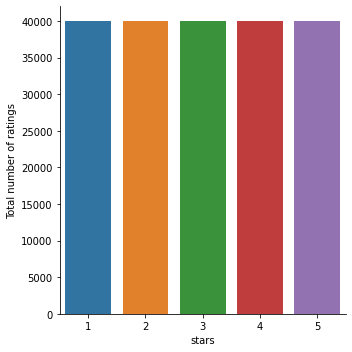

In [18]:
g = sns.factorplot("stars", data=df,kind='count')
g.set_ylabels("Total number of ratings")

In [22]:
df_rat1 = df[df.stars == 1].head(10000)
df_rat2 = df[df.stars == 2].head(10000)
df_rat3 = df[df.stars == 3].head(10000)
df_rat4 = df[df.stars == 4].head(10000)
df_rat5 = df[df.stars == 5].head(10000)

In [20]:
final = pd.concat([df_rat1, df_rat2, df_rat3, df_rat4, df_rat5])

(40000, 8)

In [ ]:

print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.reviewer_id)))
print("Total No of products  :", len(np.unique(df.product_id)))

In [25]:
reviews_per_user = df.groupby(by='reviewer_id')['stars'].count().sort_values(ascending=False)

reviews_per_user.head()

reviewer_id
reviewer_en_0857640    5
reviewer_en_0953455    4
reviewer_en_0078203    4
reviewer_en_0358974    4
reviewer_en_0115189    4
Name: stars, dtype: int64

In [26]:
reviews_per_user.describe()

count    196745.000000
mean          1.016544
std           0.134122
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: stars, dtype: float64

In [ ]:
# review_matrix = df.pivot_table(values='stars', index='reviewer_id', columns='product_id')

## product category classification using reviews

### I tried to use spacy for this but then I went with a shorter approach with the time in mind

### here, am using a simple CountVectorizer to create an embedding for each of the product review and then using it to do the classification using Naive Bayes classifier.

### I was really running behind so I didn't have time to implement Spacy or other advanced NLP techniques

In [27]:
# making numeric labels out of string labels

labels = df['product_category'].unique()
i = 0
idx2class = {}
class2idx = {}
for tp in labels:
    idx2class[i] = tp
    class2idx[tp] = i
    i += 1

In [ ]:
df['label'] = df['product_category'].replace(class2idx)

In [ ]:
df['review_body'].str.len().max()

In [ ]:
df['review_body'].str.len().min()

In [ ]:
# cutting short the length of the review to make it work on a local machine

df['review_body_100'] = df['review_body'].str.slice(0,100)

In [ ]:
df['review_body_100'].str.len().max()

In [ ]:
df.product_category.value_counts().to_frame()

In [ ]:
count_vec = CountVectorizer()
bow = count_vec.fit_transform(df['review_body_100'])
bow = np.array(bow.todense())

In [ ]:
X = bow # The features we want to analyse
y = df['label'] # The labels, in this case feedback

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
model = MultinomialNB().fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

## bonus task - recommendation

### We have 196745 unique users and 185541 unique products. With 200k reviews, the review matrix is highly sparse. I am planning to use SVD for this kind of data.

In [28]:
min_rating = df.stars.min()
max_rating = df.stars.max()

In [29]:
reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(df[['reviewer_id', 'product_id', 'stars']], reader)

In [8]:
svd = SVD(n_epochs=10)
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

In [ ]:
print("Average MAE: ", np.average(results["test_mae"]))
print("Average RMSE: ", np.average(results["test_rmse"]))

In [ ]:
# param_grid = {
#   'n_factors': [20, 50, 100],
#   'n_epochs': [5, 10, 20]
# }
 
# grid = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10)
# grid.fit(data)
 
# print(grid.best_score['rmse'])
# print(grid.best_params['rmse'])



## best params were 20; 20 as a result of the grid search above

In [10]:
# converting dataset to trainset: It's a "Surprise" thing
trainset = data.build_full_trainset()

# best hyperparameters
# best_factor = grid.best_params['rmse']['n_factors']
# best_epoch = grid.best_params['rmse']['n_epochs']

best_factor = 20
best_epoch = 20

svd = SVD(n_factors=best_factor, n_epochs=best_epoch)
 
# Train the algorithm on the trainset
svd.fit(trainset)

In [11]:
df['product_id'].unique()

array(['product_en_0740675', 'product_en_0440378', 'product_en_0399702',
       ..., 'product_en_0402982', 'product_en_0873374',
       'product_en_0843981'], dtype=object)

In [12]:
df.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,en_0964290,product_en_0740675,reviewer_en_0342986,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en,furniture
1,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing...,Not use able,en,home_improvement
2,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and ...,The product is junk.,en,home
3,en_0044972,product_en_0444063,reviewer_en_0656967,1,This product is a piece of shit. Do not buy. D...,Fucking waste of money,en,wireless
4,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct ...,bubble,en,pc


In [16]:
total_prods = df['product_id'].unique()

In [15]:
reviewed_prods = df.loc[df['reviewer_id'] == 'reviewer_en_0342986', "product_id"]

In [17]:
np.setdiff1d(total_prods, reviewed_prods)

array(['product_en_0000010', 'product_en_0000012', 'product_en_0000013',
       ..., 'product_en_0999984', 'product_en_0999987',
       'product_en_0999988'], dtype=object)

### generating recommendation for a reviewer

In [24]:
def generate_recommendation(model, reviewer_id, df, n_items):
    
    # Get a list of all movie IDs from dataset
    # movie_ids = ratings_df["movieId"].unique()
    total_prods = df['product_id'].unique()

    # Get a list of all movie IDs that have been watched by user
    # movie_ids_user = ratings_df.loc[ratings_df["userId"] == user_id, "movieId"]
    reviewed_prods = df.loc[df['reviewer_id'] == 'reviewer_en_0342986', "product_id"]
    
    # Get a list off all movie IDS that that have not been watched by user
    prods_to_pred = np.setdiff1d(total_prods, reviewed_prods)
    

    # Apply a rating of 3 to all interactions (only to match the Surprise dataset format)
    test_set = [[reviewer_id, product_id, 3] for product_id in prods_to_pred]

    # Predict the ratings and generate recommendations
    predictions = model.test(test_set)
    pred_ratings = np.array([pred.est for pred in predictions])
    print("Top {0} item recommendations for user {1}:".format(n_items, reviewer_id))
    # Rank top-n movies based on the predicted ratings
    index_max = (-pred_ratings).argsort()[:n_items]
    for i in index_max:
        prod_id = prods_to_pred[i]
        print(df[df["product_id"]==prod_id]["product_id"].values[0], pred_ratings[i])
 
 
# define which user ID that we want to give recommendation
reviewer_id = 'reviewer_en_0342986'
# define how many top-n movies that we want to recommend
n_items = 10
# generate recommendation using the model that we have trained
generate_recommendation(svd,reviewer_id,df,n_items)

Top 10 item recommendations for user reviewer_en_0342986:
product_en_0300119 3.4014368468205354
product_en_0591465 3.397451108705214
product_en_0051923 3.343636356089496
product_en_0878156 3.3364925853563845
product_en_0019714 3.3296992515264936
product_en_0586296 3.324148618271177
product_en_0210429 3.315949341574141
product_en_0965309 3.314791126620845
product_en_0995776 3.3045761992307288
product_en_0221087 3.2997161212152526


## using spacy

In [ ]:
punctuations = string.punctuation
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS
lemmatizer = spacy.lang.en.English()
parser = English()

In [ ]:
def my_preprocessor(doc):
    return(unescape(doc).lower())

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens])

In [ ]:
custom_vec = CountVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer)

In [ ]:
def spacy_tokenizer(sentence):
    
    # Creating our token object which is used to create documents with linguistic annotations
    print (sentence)
    mytokens = parser(sentence)
    
    print (mytokens)
    
    # lemmatizing each token and converting each token in lower case
    # Note that spaCy uses '-PRON-' as lemma for all personal pronouns lkike me, I etc
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    print (mytokens)
    
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations]
    
    # Return preprocessed list of tokens
    return mytokens

In [ ]:
spacy_tokenizer("Does not play with with the two cases i bought")

In [ ]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        """Override the transform method to clean text"""
        return [clean_text(text) for text in X]
    
    def fit(self, X, y= None, **fit_params):
        return self
    
    def get_params(self, deep= True):
        return {}

# Basic function to clean the text
def clean_text(text):
    """Removing spaces and converting the text into lowercase"""
    return text.strip().lower() 

In [ ]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range = (1,1))

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [ ]:
X = df['review_body'] # The features we want to analyse
y = df['product_category'] # The labels, in this case feedback

In [ ]:
X[1]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:


classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline ([("cleaner", predictors()),
                 ("vectorizer", bow_vector),
                 ("classifier", classifier)])

# Model generation
pipe.fit(X_train, y_train)